# Lab 1 | Regressions | Walkthrough

In this walkthrough, our goal will be to use a regression to predict the salary of an NHL player. The NHL is the world's best professional ice hockey league. In [ice hockey](https://en.wikipedia.org/wiki/Ice_hockey), two teams play against each other on an ice rink and try to score more goals than their opponent.

Anyways, to predict the salaries, we will use a dataset containing various metrics about every player in the pre-cited league during the 2016-17 season.

### Step 1 | Exploratory Data Analysis and Data Cleaning

Data is inherently needed when performing machine learning, so the first step in any project is to load and explore the data. The exploration, commonly referred to as Exploratory Data Analysis (EDA) is essential, as it helps us spot weaknesses in the data (duplicate rows, missing data, outliers, etc.) and can guide our decision in how to manipulate it before fitting a model (or while trying to improve it).

In [1]:
#install packages if needed
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install statsmodels
!pip3 install scikit-learn
!pip3 install seaborn

In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [3]:
# Load the dataset
nhl = pd.read_csv('nhl_2016_17.csv')
display(nhl.head())
print(nhl.shape)

,name,born,height,weight,position,games_played,goals,assists,plus_minus,penalty_minutes,salary
0,Spencer Abbott,1988,69,170,LW,1,0,0,0,0,$575'000.00
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,50,$5'500'000.00
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,4,$842'500.00
3,Noel Acciari,1991,70,208,C,29,2,3,3,16,$892'500.00
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,2,$625'000.00


(888, 11)


When working with a dataset, often the first challenge is understanding what each of the rows mean. Thus, it is often advised to carefully read the data-dictionary. In our case, the columns represent the following:
- `name`: A player's name
- `born`: A player's year of birth
- `heigh`: A player's height in inches
- `weight`: A player's weight in pounds
- `position`: A player's position
- `games_played`: The number of games a player played during the season
- `goals`: The number of goals scored by the player during the season
- `assists`: The number of assists recorded by the player during the season
- `plus_minus`: The number of times a player was on the ice when his team scored a goal minus the number of times he was on the ice when the opposing team scored a goal at even strength or short-handed
- `penalty_minutes`: The number of penalty minutes the player collected
- `salary`: A player's salary

After understanding what each column measures, one must understand which type of data is in each column as our treatment/interpretation of them depends on it. As you know, there are four types of data:

- Numerical:
    - Discrete: integer numbers (e.g., 5, 6, 7) → distinctness, order, addition, multiplication
    - Continuous: float numbers (e.g., 5.25, 5.50, 5.75) → distinctness, order, addition, multiplication
- Categorical:
    - Ordinal: distinct and can be ordered (e.g., low, medium, high) → distinctness, order
    - Nominal: distinct but cannot be ordered (e.g., male, female) → distinctness

The distinction between those categories is not always obvious and each category bring different attributes with them:

- Distinctness: =, ≠
- Order: <, >
- Addition: +, -
- Multiplication: ×, ÷

Note that since numerical discrete and numerical continuous have the same characteristics, their distinction is often vague. Therefore, most of the time, if a variable can take many different integer values, it is called numerical continuous.

In our case, the types of data are the following:

| Types of Data | Columns |
| :---: | :---: |
| Numerical discrete | `born` |
| Numerical continuous | `height`, `weight`, `games_played`, `goals`, `assists`, `plus_minus`, `penalty_minutes`, `salary` |
| Categorical Ordinal | None here :-( |
| Categorical Nominal | `position`|

Now that we truly understand our variables, we can start with the EDA. One thing to look at are the missing variables, which one needs to decide how to handle on a case-by-case basis. This can involve:

- Deleting an entire column: If too many values are missing and the column is not critical
- Deleting rows with one, some, or all variables missing: If only a small pencentage of rows are affected on important variables
- Manually collect the missing data: Tedious and could introduce measurement deviations
- Input the mean, median, or an arbitrary number: Sometimes hard to justify and required expert knowledge

We notice that there are 14 players with missing values for their salary. Since 14/888 rows are not a lot, we will simply drop them.

In [4]:
# Lookup the missing values
print(nhl.isna().sum())

# Remove the players with missing salaries
nhl.dropna(axis=0, subset='salary', inplace=True)
print(f'remaining number of rows: {len(nhl)}')

name                0
born                0
height              0
weight              0
position            0
games_played        0
goals               0
assists             0
plus_minus          0
penalty_minutes     0
salary             14
dtype: int64
remaining number of rows: 874


Another thing to look at are the datatypes of the columns and check that they are in accordance with what we expect.

We notice that the numerical variables are in `int64` while the categorical variables are in `object`, which is as expected. The one exception is the `salary` column, which is a string when it should be a number. Hence, it is something to fix before we can fit the model.

In [8]:
# List the datatypes of all columns
print(nhl.dtypes)

# Transform the salary column to numeric
nhl['salary'] = pd.to_numeric(
    nhl['salary'].apply(
        lambda sal: str(sal).strip('$').replace("'", '')
    )
)
nhl.head()

name                   object
born                    int64
height                  int64
weight                  int64
position               object
games_played            int64
goals                   int64
assists                 int64
plus_minus              int64
ln_penalty_minutes    float64
salary                float64
dtype: object


,name,born,height,weight,position,games_played,goals,assists,plus_minus,ln_penalty_minutes,salary
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,3.912023,5500000.0
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,1.386294,842500.0
3,Noel Acciari,1991,70,208,C,29,2,3,3,2.772589,892500.0
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,0.693147,625000.0
5,Sebastian Aho,1997,71,172,RW,82,24,25,-1,3.258097,925000.0


We can then turn our attention to the numerical variables. With `df.describe()`, we can easily get a lot of summary statistics for them. This is a way to get a good sense for the data and find potential outliers. However, plotting might be just as good to do this.

Note that use histograms in this example, which are usually the standard (especially when it comes to looking at the general distribution and spotting outliers), but scatterplots, boxplots, etc. are also powerful visualizations.

We will log-transform the `penalty_minutes` variable to show you how it is done, even if in this case it makes little sense. However, it is a good example as it forces you to think about how to treat values that cannot be log-transformed (i.e., <= 0). One way to deal with them is to delete the observations (which we use here) while one could also replace the 0 with an arbitrarily small positive number.

,born,height,weight,games_played,goals,assists,plus_minus,ln_penalty_minutes,salary
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,7.720000e+02
mean,1989.730570,73.098446,201.369171,56.532383,8.630829,14.489637,-0.336788,2.957298,2.512181e+06
std,4.389582,2.105677,15.041912,25.491745,8.726555,12.704305,10.566351,0.982811,2.371108e+06
min,1972.000000,66.000000,157.000000,1.000000,0.000000,0.000000,-34.000000,0.693147,5.750000e+05
25%,1987.000000,72.000000,191.000000,38.000000,2.000000,4.000000,-6.000000,2.484907,7.925000e+05
50%,1991.000000,73.000000,200.000000,66.000000,6.000000,11.000000,-1.000000,3.178054,1.100000e+06
75%,1993.000000,75.000000,211.000000,79.000000,13.000000,22.000000,5.000000,3.637586,4.000000e+06
max,1998.000000,81.000000,265.000000,82.000000,44.000000,70.000000,34.000000,5.036953,1.400000e+07


KeyError: 'penalty_minutes'

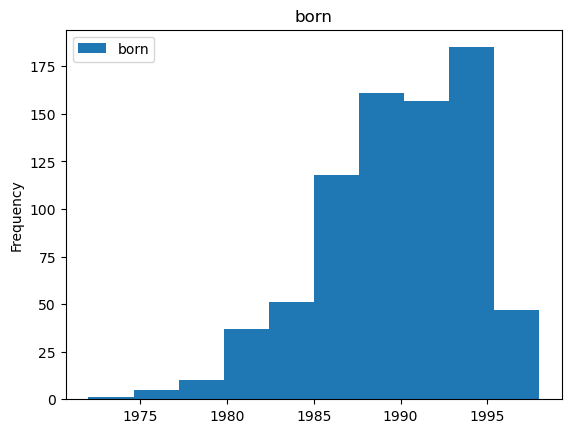

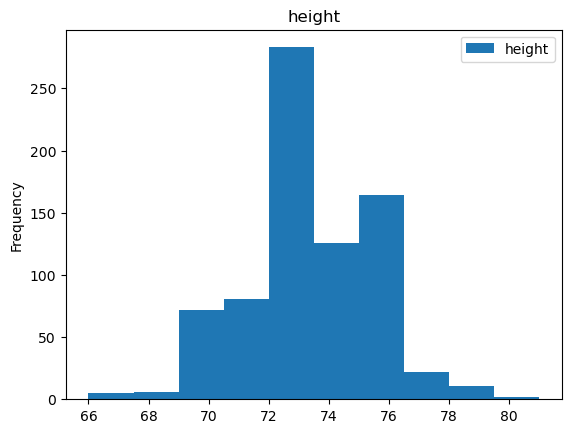

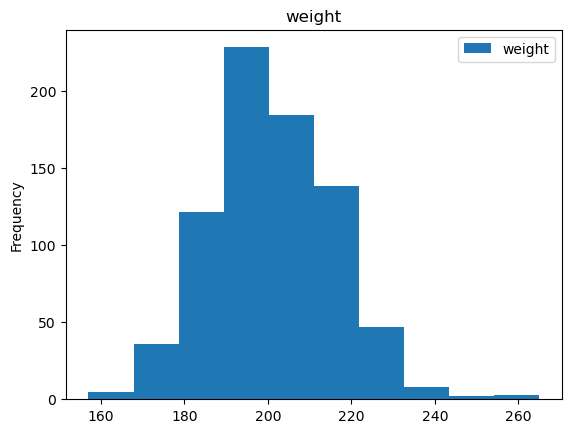

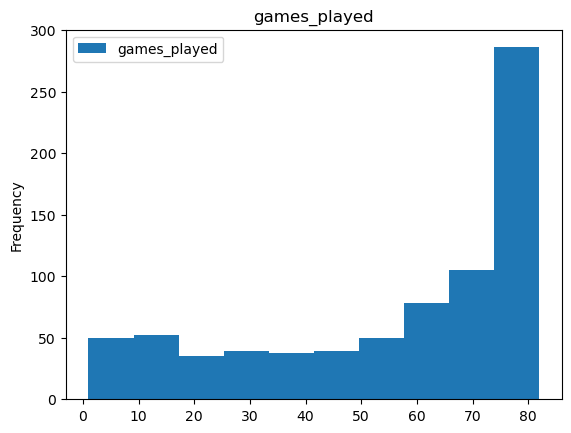

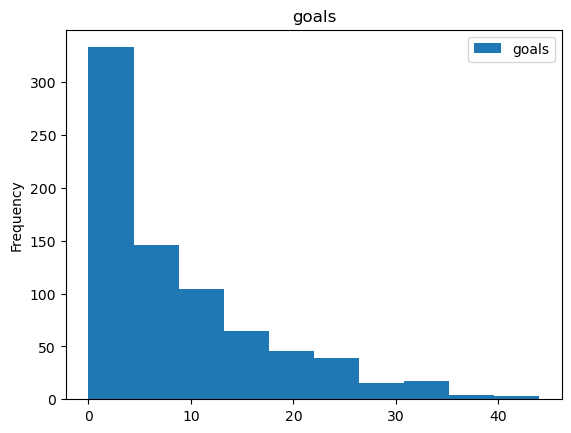

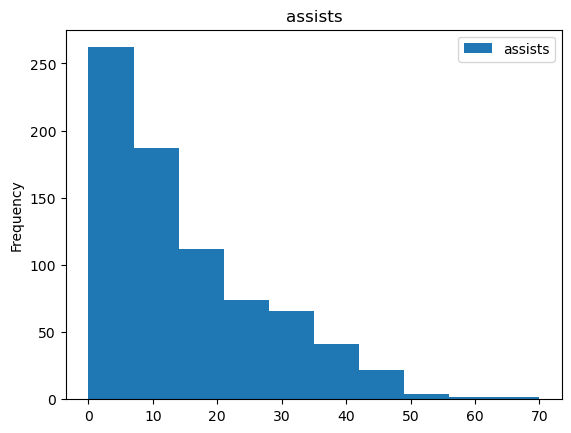

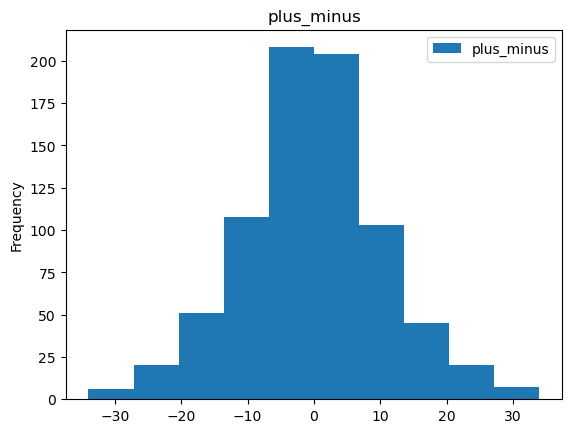

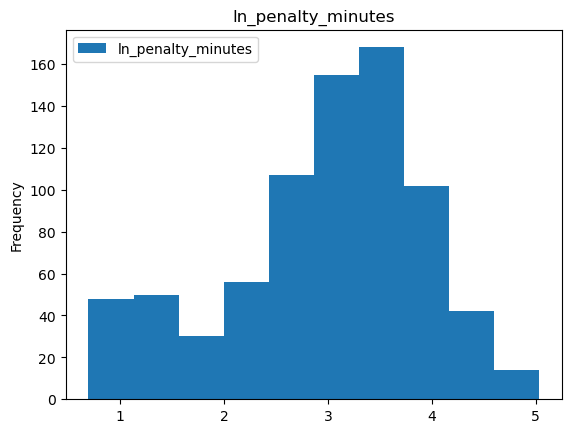

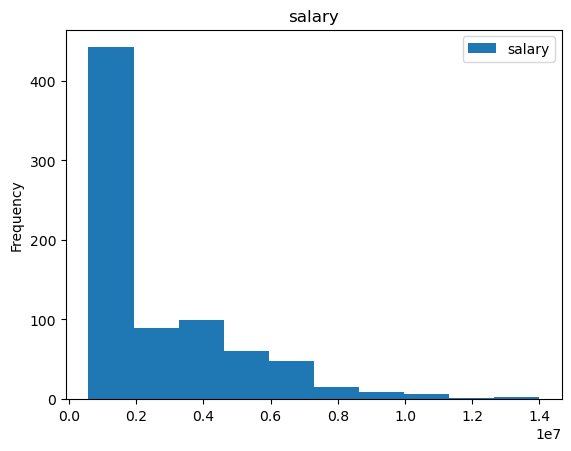

In [9]:
# Display is used to show the output when a command follows it
display(nhl.describe())

# Plot all numerical variables
for col in nhl.select_dtypes(['int64', 'float64']).columns:
    nhl.plot(y=col, kind='hist', title=col)

# Log-transform penalty_minutes
nhl = nhl.loc[nhl['penalty_minutes'] > 0]
nhl['penalty_minutes'] = np.log(nhl['penalty_minutes'])
nhl.rename(columns={'penalty_minutes': 'ln_penalty_minutes'}, inplace=True)

display(nhl.describe())

As mentioned above, other types of visualizations are also very powerful for EDA. The `Seaborn` library is quite handy as it allows us to easily create graphs. Below are examples of boxplots, scatterplots, and pairplots.

<Axes: xlabel='position', ylabel='salary'>

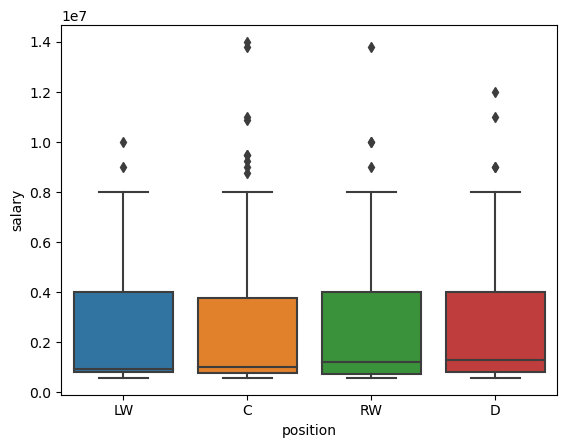

In [10]:
# Boxplot displaying the salary per position
sns.boxplot(x='position', y='salary', data=nhl)

<Axes: xlabel='assists', ylabel='salary'>

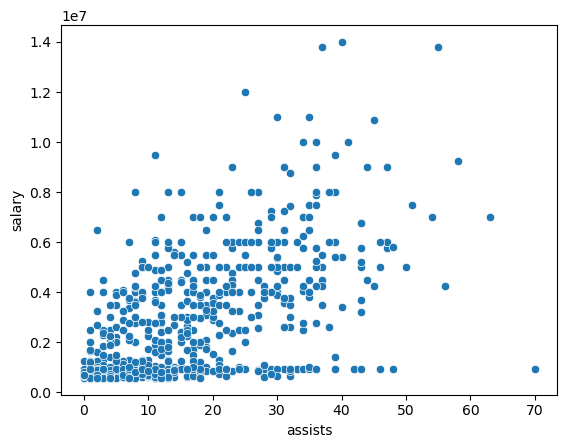

In [11]:
# Scatterplot displaying the relationship between assists and salary
sns.scatterplot(x='assists', y='salary', data=nhl)

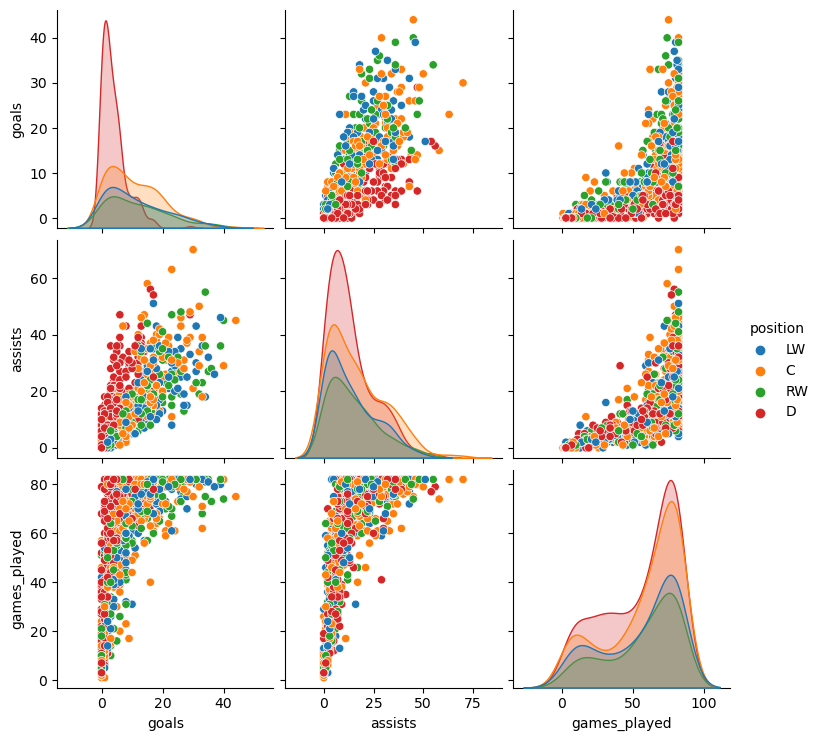

In [12]:
# Pairplot on goals, assists, and games_played with a hue on position
sns.pairplot(nhl, vars = ['goals', 'assists', 'games_played'], hue='position')

Now, we can turn our attentions to the categorical variables and examine those. Luckily, the examination does not change much from the numerical variables.

Obviously, something needs to be done to categorical variables for them to be interpretable by a model. A common approach is to use dummy variables (also called one-hot encoding, label encoding being the other option) where a column is replaced by a binary column for each possible values. In our case, there are four possible values for the `position` so we will have just as many dummy columns.

However, this creates multicollinearity  as, exactly one of `position_C`, `position_D`, `position_LW`, or `position_RW` will take the value `1` and the others will take the value `0`. Hence, we will have to remove one of the variables from the regression later on.

ValueError: columns overlap but no suffix specified: Index(['position_C', 'position_D', 'position_LW', 'position_RW'], dtype='object')

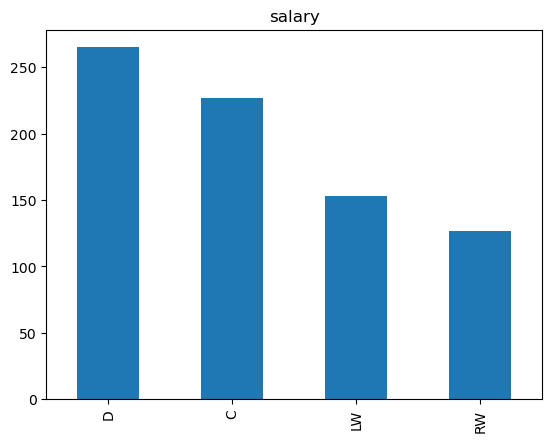

In [14]:
# Plot the categorical column
nhl['position'].value_counts().plot(y=col, kind='bar', title=col)

# Create the dummy variable for the position
nhl = nhl.join(pd.get_dummies(nhl['position'], prefix='position'))

nhl

All along the data cleaning process, you should always keep track of the number of rows and columns. This might seem trivial, but it is very easy that a method you use duplicates the rows, creates unnecessary index columns, etc. This is easily done with `len(df)`

Another thing you should always check is that you don't have any duplicate rows (if they should not exist in your data). If you have an `id` column (`name` in our case), you can simply use `df['id'].value_counts().max()`

In [15]:
# Check the number of rows
print(f'Number of rows: {len(nhl)}')

# Check for duplicates on the name
print(f'Most occurances of the same name: {nhl["name"].value_counts().max()}')

# Display the data
display(nhl.head())
print(nhl.shape)

Number of rows: 772
Most occurances of the same name: 1


,name,born,height,weight,position,games_played,goals,assists,plus_minus,ln_penalty_minutes,salary,position_C,position_D,position_LW,position_RW
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,3.912023,5500000.0,0,0,1,0
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,1.386294,842500.0,0,0,1,0
3,Noel Acciari,1991,70,208,C,29,2,3,3,2.772589,892500.0,1,0,0,0
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,0.693147,625000.0,0,0,1,0
5,Sebastian Aho,1997,71,172,RW,82,24,25,-1,3.258097,925000.0,0,0,0,1


(772, 15)


Anyways, we have finally finished the data cleaning! Remember, this is usually 80% of the work... so now, let's turn to the actual machine learning!

### Step 2 | Training the Model

For now, in your statistics classes, you have always run regressions on the entire dataset. This can easily be done in python with the `StatsModels` library.

Let's imagine that we want to predict `salary` with `goals` and a constant: $ \boxed{salary_i = \beta_0 + \beta_1 \cdot goals_i + \varepsilon_i} $

As one can see, the output gives us all of the metrics we are used to and if a player scores no goals, his expected salary is \$1'393'000 and each additional goal adds an additional \$129'700 to it.

In [16]:
# Regress the salary on goals and a constant
regression = smf.ols('salary ~ goals', data=nhl).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     227.0
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           3.77e-45
Time:                        11:02:55   Log-Likelihood:                -12327.
No. Observations:                 772   AIC:                         2.466e+04
Df Residuals:                     770   BIC:                         2.467e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.393e+06   1.06e+05     13.195      0.0

We can easily visualize this regression.

Text(0.5, 1.0, 'Salary vs Goals')

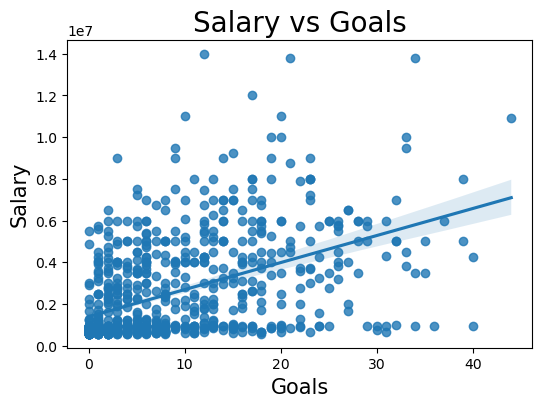

In [17]:
plt.figure(figsize=(6,4))
sns.regplot(x='goals', y='salary', data=nhl)
plt.xlabel("Goals", fontsize=15)
plt.ylabel("Salary", fontsize=15)
plt.title('Salary vs Goals', fontsize=20)

Now, one can of course remove the constant to get to the following regression: $ \boxed{salary_i = \beta \cdot goals_i + \varepsilon_i} $

In [18]:
# Removing the constant
regression = smf.ols('salary ~ goals - 1', data=nhl).fit()
print(regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                 salary   R-squared (uncentered):                   0.554
Model:                            OLS   Adj. R-squared (uncentered):              0.554
Method:                 Least Squares   F-statistic:                              958.4
Date:                Fri, 12 Jan 2024   Prob (F-statistic):                   2.18e-137
Time:                        11:03:15   Log-Likelihood:                         -12406.
No. Observations:                 772   AIC:                                  2.481e+04
Df Residuals:                     771   BIC:                                  2.482e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Adding more variables is also quite straightforward. For instance, if we were to run the following regression: $ \boxed{salary_i = \beta_0 + \beta_1 \cdot goals_i + \beta_2 \cdot games\_played_i + \varepsilon_i} $

In [19]:
# Regress the salary on goals, games_played, and a constant
regression = smf.ols('salary ~ goals + games_played', data=nhl).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     142.5
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           2.22e-53
Time:                        11:04:12   Log-Likelihood:                -12305.
No. Observations:                 772   AIC:                         2.462e+04
Df Residuals:                     769   BIC:                         2.463e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.935e+05   1.81e+05      2.175   

Now, let's get a few easy cases out of the way:
- Using log-transformed variables is quite easy, because nothing expect the interpretation of the coefficients changes.
- We can also use interaction effects by multiplying the variables (e.g., goals × assists).
- Finally, one can also use higher-order coefficients (e.g., games_played^2).

For instance, if we were to run the regression below, how would you interpret the coefficients?

$ \boxed{salary_i = \beta_0 + \beta_1 \cdot ln(penalty\_minutes) + \beta_2 \cdot goals_i + \beta_3 \cdot assists_i + \beta_4 \cdot goals_i \cdot assists_i + \beta_5 \cdot games\_played^2 + \varepsilon_i} $

In [20]:
regression = smf.ols('salary ~ ln_penalty_minutes + goals*assists + np.power(games_played, 2)', data=nhl).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     96.45
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           8.17e-79
Time:                        11:04:16   Log-Likelihood:                -12239.
No. Observations:                 772   AIC:                         2.449e+04
Df Residuals:                     766   BIC:                         2.452e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

For our categorical variables, remember that we created dummy variables. However, we have to watch out for multicollinearity, which is why we will leave out the position_C variable.

In this case, the coefficients of the position dummy variables represent the change in expected salary of a player compared to the case where he is a center (position_C = 1). For instance, if a player is a defenseman (position_D = 1), he will on average earn $854'700 more than if he were a center.

$ \boxed{salary_i = \beta_0 + \beta_1 \cdot goals_i + \beta_2 \cdot games\_played_i + \beta_3 \cdot ln\_penalty\_minutes + \beta_4 \cdot position\_C + \beta_5 \cdot position\_LW + \beta_6 \cdot position\_RW + \varepsilon_i} $

In [21]:
regression = smf.ols('salary ~ goals + games_played + ln_penalty_minutes + position_D + position_LW + position_RW', data=nhl).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     54.54
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.67e-56
Time:                        11:04:22   Log-Likelihood:                -12290.
No. Observations:                 772   AIC:                         2.459e+04
Df Residuals:                     765   BIC:                         2.463e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.614e+04   2.49

The good news is that we do not necessarily have to create the dummy variables ourselves as the models often do it for us with categorical variables. However, if we wanted to create a dummy variable for a certain threshold (e.g., players born before/after 1990), we would have to manually create the dummy variables just as we did.

Note two things:
- The regression does drop a (random) possible value of `position` to avoid multicollinearity
- The coefficients are the same as when we use the dummy variables

Hence, manually creating dummy variables on categorical variables has the advantage of letting us choose which potential variable to drop to avoid multicollinearity, which is often important for interpretability (you want to drop the baseline value)

In [22]:
# Regression without the manual dummy variables
regression = smf.ols('salary ~ goals + games_played + ln_penalty_minutes + position', data=nhl).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     54.54
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.67e-56
Time:                        11:04:25   Log-Likelihood:                -12290.
No. Observations:                 772   AIC:                         2.459e+04
Df Residuals:                     765   BIC:                         2.463e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.614e+04   2.49

For now, we have horribly disregarded one of the fundamental principles of machine learning; the train-test split. Actually, with (almost) all machine learning models we will use throughout the course, you will follow the following steps:

1. Load the data and clean it
2. Split the data into training and test sets
3. Data-normalization
4. Create/fit the regression
5. Metrics to evaluate the model (R2, MAE, MSE)
6. Retrieve the coefficients
7. Make predictions with the model

Luckily, we have already covered step 1 in length, so let's get right into step 2!

Note: We used the `StatsModels` library, which is designed for inference, to run the regressions. Hence, displaying the coefficients and the various metrics was very easy. Now, we will use `sklearn` is a true machine learning library that focuses on predictions. Keep that in mind as you will see that looking up the coefficients is not as easy anymore.

##### 2. Splitting the dataset

Sklearn has a very useful module to separate your dataset in a training and in a testing set. The training set will be used to retrieve the best values of the weights according to a combination of input/output while the test set will be used to evaluate/predict our model. Since our model will be trained on particular values, we want to test our data on a new set of data (the test set)

The test size here is of 20% of the original data.

In [23]:
# Separate the features from the target variable
features = 'goals', 'games_played', 'ln_penalty_minutes', 'position_D', 'position_LW', 'position_RW'
y = nhl[['salary']]
X = nhl[['goals', 'games_played', 'ln_penalty_minutes', 'position_D', 'position_LW', 'position_RW']]

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% of the data in the test set
    random_state=12,    # Makes sure the split is the same every time
    shuffle=True        # Shuffles the rows before splitting
)

display(X_train)
display(y_train)

display(X_test)
display(y_test)

,goals,games_played,ln_penalty_minutes,position_D,position_LW,position_RW
358,10,82,3.401197,0,0,0
394,6,81,2.302585,0,0,0
462,8,65,3.465736,0,0,0
77,4,81,3.332205,1,0,0
645,0,29,3.784190,1,0,0
...,...,...,...,...,...,...
736,13,82,2.639057,0,0,0
268,7,75,2.890372,0,0,0
282,19,69,2.639057,0,0,0
437,0,22,1.386294,1,0,0


,salary
358,900000.0
394,1000000.0
462,700000.0
77,3800000.0
645,1250000.0
...,...
736,867500.0
268,1150000.0
282,850000.0
437,925000.0


,goals,games_played,ln_penalty_minutes,position_D,position_LW,position_RW
579,5,44,3.496508,1,0,0
526,0,18,2.079442,1,0,0
401,2,25,1.791759,0,1,0
478,16,82,2.772589,0,0,0
582,22,81,3.465736,0,0,0
...,...,...,...,...,...,...
4,1,7,0.693147,0,1,0
408,19,81,4.189655,0,1,0
174,0,3,1.791759,0,0,0
701,4,71,3.218876,1,0,0


,salary
579,832500.0
526,600000.0
401,925000.0
478,5000000.0
582,925000.0
...,...
4,625000.0
408,4450000.0
174,575000.0
701,3750000.0


##### 3. Normalize the Data

Generally, you should normalize the data right after splitting the dataset. The normalization is important here to reduce the variance of our model and get better results. We skip this step for now.

The sklearn has several tools to normalize the data. For instance, one can use the MinMaxScaler module to normalize the data. This estimator scales and translates each feature individually such that it is in the given range on the training set (e.g., between zero and one).

This is an example of how to use it:

```python
from sklearn.preprocessing import MinMaxScaler

# Define the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler
scaler.fit(X_train)

# Transform the train and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# The two last steps above can be merged into one
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

With this code, the X_train data is now bounded between 0 and 1, however, that is not necessarily true for the X_test data.

##### 4. Create and Fit the Model

To predict the target variable, we will use a simple linear regression as we have done previously. For this, we will first create the model (stipulate the parameters) before fitting it to the training data.

You will find that we do not have the same coefficients as before. This is because we are not running the regression on the same set of data (remember, we did the train-test split). However, if you were to fit the model on X and y, you would find the exact same coefficients.

In [24]:
# Create the model
model = LinearRegression(fit_intercept= True)

# Fit the model on the training data
model.fit(X_train, y_train)

# Retrieve the coefficients
print(f'Intercept: {model.intercept_[0]}')
print(f'Feature coefficients: \n{pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1)}')

Intercept: -111275.14519522479
Feature coefficients: 
                    0              0
0               goals  116253.876670
1        games_played   13011.776476
2  ln_penalty_minutes  206353.546080
3          position_D  939345.112218
4         position_LW  -78444.621232
5         position_RW   51953.349257


### Step 3 | Evaluate the Model

Now that we have a model, it is time to evaluate it. For this, we commonly use three metrics: MAE, MSE, and R2.

We can use these metrics on both the training and the test data. However, it is mostly the test metrics we are interested in. This is logical as the goal of machine learning is to make predictions on data never seen before.

One would expect the training metrics to be better than the testing metrics because that is what the model has been fitted upon. However, that is not necessarily the case.

In [21]:
# Evaluate on the test set
predictions = model.predict(X_test)
print(f'Test MAE:\t{mean_absolute_error(y_test, predictions)}')
print(f'Test MSE:\t{mean_squared_error(y_test, predictions)}')
print(f'Test R2:\t{r2_score(y_test, predictions)}\n')

# Evaluate on the training set
predictions = model.predict(X_train)
print(f'Train MAE:\t{mean_absolute_error(y_train, predictions)}')
print(f'Train MSE:\t{mean_squared_error(y_train, predictions)}')
print(f'Train R2:\t{r2_score(y_train, predictions)}')

Test MAE:	1482785.2411945409
Test MSE:	4145578762679.321
Test R2:	0.2961215089592517

Train MAE:	1486357.5184966298
Train MSE:	3888757782261.182
Train R2:	0.2976174299524573


Then, one can use these metrics to select the best model (i.e., the one with the best training metrics). To illustrate how this works on an oversimplified example, we will see how the training and testing MSE evolve as we add features to the model (starting with just the year of birth).

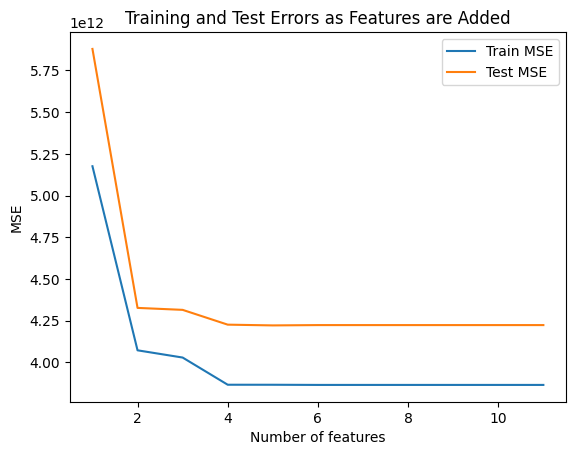

In [22]:
# Arrays to save the different errors
train_err = []
test_err = []

# Features to add iteratively
features = [
    'born', 'height', 'weight', 'games_played', 'goals',
    'assists', 'plus_minus', 'ln_penalty_minutes', 'salary',
    'position_D', 'position_LW', 'position_RW'
]

# Iterate over the number of features
for nbr_col in range(1, len(features)):
    # Select the good number of features for X
    X_temp = X[X.columns[:nbr_col]]

    # Split the dat set
    X_train, X_test, y_train, y_test = train_test_split(
        X_temp,
        y,
        test_size=0.2,
        random_state=8  # Change the random state and see the effect on the errors
    )

    # Create the linear model
    LR = LinearRegression(fit_intercept=False)

    # Fit the linear model
    LR.fit(X_train, y_train)
    
    # Compute the MSEs
    train_err.append(mean_squared_error(y_train, LR.predict(X_train)))
    test_err.append(mean_squared_error(y_test, LR.predict(X_test)))

# Visualize
plt.title('Training and Test Errors as Features are Added')
plt.plot(range(1, len(features)), train_err, label='Train MSE')
plt.plot(range(1, len(features)), test_err, label='Test MSE')
plt.legend(fontsize=10)
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.show()

As we can see, the model does perform better after more than 4 features, so here we would take the first four features for our final model.

However, in a real scenario, we would use different approaches to determine which features those should be (not necessarily start with the year of birth, etc.).

Finally, look at how the train and test MSEs evolve. While the test error is, as expected, higher than the training error, we do not observe overfitting. This is because the model is quite simple (i.e., a linear model), however, it will eventually kick in and negatively affect the train MSE. This would for instance be the case if we were to add higher-order variables (e.g., $goals^2$).

### Step 4 | Making Predictions

Finally, after having found the optimal model, we can start doing what machine learning is for; predictions.

We have actually already done so when evaluating the models with `model.predict(X)` and it really is that simple.

Let's say we would like to predict what a right winger would expect to make if he scored 12 goals in 55 games and had 6 penalty minutes. The model in this case predicts a salary of $2'421'108.

In [23]:
# Load our simple model from the beginning
features = ['goals', 'games_played', 'ln_penalty_minutes', 'position_D', 'position_LW', 'position_RW']
y = nhl[['salary']]
X = nhl[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12, shuffle=True
)

model = LinearRegression(fit_intercept= True)
model.fit(X_train, y_train)

# Predict our imaginary player
model.predict(np.array([12, 55, np.log(6), 0, 0, 1]).reshape(1, -1))

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[2421108.35047664]])